# RedHat - Classifying Customer Potential

### Kaggle Competition

## Problem Statement

Like most companies, Red Hat is able to gather a great deal of information over time about the behavior of individuals who interact with them. They’re in search of better methods of using this behavioral data to predict which individuals they should approach—and even when and how to approach them.

In this competition, Kagglers are challenged to create a classification algorithm that accurately identifies which customers have the most potential business value for Red Hat based on their characteristics and activities.

With an improved prediction model in place, Red Hat will be able to more efficiently prioritize resources to generate more business and better serve their customers.

## Data

This competition uses two separate data files that may be joined together to create a single, unified data table: a **people file and an activity file.**

The **people file** contains all of the **unique people** (and the corresponding characteristics) that have performed activities over time. **Each row in the people file represents a unique person.** Each person has a unique people_id.

The **activity file** contains all of the **unique activities (and the corresponding activity characteristics) that each person has performed over time.** Each row in the activity file represents a unique activity performed by a person on a certain date. Each activity has a unique activity_id.

The challenge of this competition is to predict the potential business value of a person who has performed a specific activity. **The business value outcome is defined by a yes/no field attached to each unique activity in the activity file.** The outcome field indicates whether or not each person has completed the outcome within a fixed window of time after each unique activity was performed.

The activity file contains several different categories of activities. Type 1 activities are different from type 2-7 activities because there are more known characteristics associated with type 1 activities (nine in total) than type 2-7 activities (which have only one associated characteristic).

To develop a predictive model with this data, you will likely need to join the files together into a single data set. The two files can be joined together using **person_id as the common key.** __All variables are categorical, with the exception of 'char_38'__ in the people file, which is a continuous numerical variable.

## File Names

- act_train.csv
- act_test.csv
- people.csv

## Importing Data and Libraries

In [1]:
# Import libraries needed for processing and visualizations
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

In [2]:
#define confusion matrix plotting function
labels = [0,1]
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues,labels=labels):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 16)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=0, fontsize = 16)
    plt.yticks(tick_marks, labels, fontsize = 16)
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)

In [3]:
#import csv files to pandas dataframes
df_people = pd.read_csv('people.csv')
df_act_train = pd.read_csv('act_train.csv')
df_act_test = pd.read_csv('act_test.csv')

## Inspecting Data Sizes and Concatenating Training and Test Sets

In [4]:
print (df_act_train.shape)
print (df_act_test.shape)

df_act = pd.concat([df_act_train, df_act_test], axis=0, ignore_index=True)
print (df_act.shape)

(2197291, 15)
(498687, 14)
(2695978, 15)


## Differentiating Activities and People Characteristics

In [5]:
#renaming columns to prevent overlapping column names during join
for column in df_people.columns:
    suffix = '_people'
    if 'date' in column:
        df_people = df_people.rename(columns={column:column+suffix})
    if 'char' in column:
        df_people = df_people.rename(columns={column:column+suffix})

for column in df_act.columns:
    suffix = '_activity'
    if 'date' in column:
        df_act = df_act.rename(columns={column:column+suffix})
    if 'char' in column:
        df_act = df_act.rename(columns={column:column+suffix})

## Joining available Data

In [6]:
df = pd.merge(df_act, df_people, how='left', on = 'people_id')

del df_act_train
del df_act_test
del df_people

In [7]:
#Data Summary by Column, Null v Not Null Counts
def dataInfo(tmp):
    print ('{0:3} {1!s:16} {2:8} {3:8} {4:8} {5:8} {6:8}'.format('idx','dtype','  Null', 'Not Null', '%Not Null','Unique','Column Name'))
    for i, column in enumerate(tmp.columns):
        print ('{0:3} {1!s:16} {2:8} {3:8} {4:8} {5:8} {6:8}'.format(i, tmp[column].dtype,
                                                             tmp[column].isnull().sum(), 
                                                             tmp[column].notnull().sum(),
                                                             round(tmp[column].notnull().sum()/tmp[column].shape[0],3),
                                                             tmp[column].unique().shape[0],
                                                              column))
dataInfo(df)

idx dtype              Null   Not Null %Not Null Unique   Column Name
  0 object                  0  2695978      1.0        7 activity_category
  1 object                  0  2695978      1.0  2695978 activity_id
  2 object            2498271   197707    0.073       52 char_1_activity
  3 object             197707  2498271    0.927     6970 char_10_activity
  4 object            2498271   197707    0.073       33 char_2_activity
  5 object            2498271   197707    0.073       12 char_3_activity
  6 object            2498271   197707    0.073        8 char_4_activity
  7 object            2498271   197707    0.073        8 char_5_activity
  8 object            2498271   197707    0.073        6 char_6_activity
  9 object            2498271   197707    0.073        9 char_7_activity
 10 object            2498271   197707    0.073       19 char_8_activity
 11 object            2498271   197707    0.073       20 char_9_activity
 12 object                  0  2695978      1.0      41

### Identifying Column Types and Some Cleaning

In [8]:
#Convert date_# columns to Datetime
df.date_activity = pd.to_datetime(df.date_activity, infer_datetime_format=True)
df.date_people = pd.to_datetime(df.date_people, infer_datetime_format=True)

#fill Null values with a categorical indicator
for column in df.columns:
    df[column] = df[column].fillna('type_null')

#Identify Column types
ids = ['people_id','activity_id']
dates = ['date_activity','date_people']
target = ['outcome']
act_category = ['activity_category']
group = ['group_1']

characteristics = []
for column in df.columns:
    if ('char' in column) and ('38' not in column):
        characteristics.append(column)
        
#Defining continuous and categorical variables
continuous = ['char_38_people']
categorical = act_category + characteristics

#Set aside a list of columns to be one-hot encoded
oneHot = []
binary = []
for column in categorical:
    if df[column].unique().shape[0] != 2:
        oneHot.append(column)
    else:
        binary.append(column)

#Forced binary encoding
df.char_1_people = df.char_1_people.replace(to_replace='type 1', value = 0)
df.char_1_people = df.char_1_people.replace(to_replace='type 2', value = 1)

#Generate date-based features
for date in dates:
    df[date+'_year'] = df[date].dt.year
    df[date+'_month'] = df[date].dt.month
    df[date+'_day'] = df[date].dt.day
    df[date+'_isweekend'] = (df[date].dt.weekday >= 5).astype(int)
    df = df.drop(date, axis = 1)

#re-create dates list
dates = []
for column in df.columns:
    if 'date' in column:
        dates.append(column)

### Perform OneHot Encoding

The columns identified for one-hot encoding is shown in the code above

In [9]:
def oneHotEncoder(dataframe):
    encodedCat = []
    encoded = []
    for i, item in enumerate(dates+oneHot): #added dates HERE
        print (i, item)
        if item != 'char_10_activity': #creates errors
            tmp = pd.get_dummies(dataframe[item], prefix=item)
            encoded.append(tmp)
            encodedCat = encodedCat + tmp.columns.tolist()
        
    print ('...Concatenating')
    dataframe = pd.concat( [dataframe]+encoded, axis=1) # add back into the dataframe
    print ('...Done')
    return dataframe, encodedCat

print ('Encoded Columns:')
df, encodedCat = oneHotEncoder(df)
print (df.shape)

Encoded Columns:
0 date_activity_year
1 date_activity_month
2 date_activity_day
3 date_activity_isweekend
4 date_people_year
5 date_people_month
6 date_people_day
7 date_people_isweekend
8 activity_category
9 char_1_activity
10 char_10_activity
11 char_2_activity
12 char_3_activity
13 char_4_activity
14 char_5_activity
15 char_6_activity
16 char_7_activity
17 char_8_activity
18 char_9_activity
19 char_2_people
20 char_3_people
21 char_4_people
22 char_5_people
23 char_6_people
24 char_7_people
25 char_8_people
26 char_9_people
...Concatenating
...Done
(2695978, 460)


### Defining Variables for Modeling

In [10]:
forModeling = ids + encodedCat + binary + continuous + target

df = df[forModeling]
test = df

print (df.shape)
print (test.shape)

(2695978, 432)
(2695978, 432)


### The test.outcome column is the Target, type_null differentiating between the train and test set

In [11]:
test = test[test.outcome == 'type_null']

print (test.shape)
print (df.shape)

(498687, 432)
(2695978, 432)


### The training set will remain as df

In [12]:
df = df[df.outcome != 'type_null']

print (test.shape)
print (df.shape)

(498687, 432)
(2197291, 432)


### Define Train Test Split and Cross-Validation Object

In [13]:
colX = encodedCat + binary + continuous

df[continuous] = StandardScaler().fit_transform(df[continuous])
test[continuous] = StandardScaler().fit_transform(test[continuous])

X = df[colX]
y = np.ravel(df[target].astype(float))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

cv = ShuffleSplit(n = len(y), n_iter=10, test_size=0.3, random_state=42)

In [14]:
print (test.shape)

(498687, 432)


### Sampling Joined Dataframe to facilitate GridSearch process

In [39]:
df_sampled = df.sample(frac = 0.025)
df_sampled.shape

(54932, 432)

### Define Explanatory and Response Variables

In [40]:
X_sampled = df_sampled[colX]
y_sampled = np.ravel(df_sampled[target].astype(float))

cv_sampled = ShuffleSplit(n = len(y_sampled), n_iter=3, test_size=0.3, random_state=42)

### Grid Search - SGDClassifier

In [41]:
parameters = {'alpha': [0.001, 0.01, 0.1, 1], 
              'loss':['log','modified_huber'], 
              'penalty' : ['l2','l1','elasticnet']}

sgd = SGDClassifier(n_jobs=-1, class_weight='balanced')
gs = GridSearchCV(sgd, parameters, cv=cv_sampled, verbose = 1)

gs.fit(X_sampled, y_sampled)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  2.6min finished


GridSearchCV(cv=ShuffleSplit(54932, n_iter=3, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'loss': ['log', 'modified_huber'], 'alpha': [0.001, 0.01, 0.1, 1], 'penalty': ['l2', 'l1', 'elasticnet']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [42]:
sorted(gs.grid_scores_, key=lambda x: x[1], reverse=True) #sorted grid scores

[mean: 0.85714, std: 0.00254, params: {'loss': 'log', 'alpha': 0.001, 'penalty': 'elasticnet'},
 mean: 0.85702, std: 0.00270, params: {'loss': 'log', 'alpha': 0.001, 'penalty': 'l1'},
 mean: 0.85581, std: 0.00256, params: {'loss': 'log', 'alpha': 0.001, 'penalty': 'l2'},
 mean: 0.85560, std: 0.00160, params: {'loss': 'modified_huber', 'alpha': 0.01, 'penalty': 'l2'},
 mean: 0.85441, std: 0.00310, params: {'loss': 'modified_huber', 'alpha': 0.01, 'penalty': 'elasticnet'},
 mean: 0.85350, std: 0.00235, params: {'loss': 'modified_huber', 'alpha': 0.001, 'penalty': 'elasticnet'},
 mean: 0.85279, std: 0.00060, params: {'loss': 'modified_huber', 'alpha': 0.001, 'penalty': 'l1'},
 mean: 0.85265, std: 0.00232, params: {'loss': 'modified_huber', 'alpha': 0.001, 'penalty': 'l2'},
 mean: 0.85202, std: 0.00330, params: {'loss': 'modified_huber', 'alpha': 0.01, 'penalty': 'l1'},
 mean: 0.84937, std: 0.00300, params: {'loss': 'log', 'alpha': 0.01, 'penalty': 'l2'},
 mean: 0.84711, std: 0.00240, para

In [43]:
print (gs.best_score_, gs.best_params_) #best grid score with corresponding parameters

0.857139967638 {'loss': 'log', 'alpha': 0.001, 'penalty': 'elasticnet'}


Train/Test Accuracy: 0.860 

Confusion Matrix:
[[284282  82511]
 [  9526 282869]]


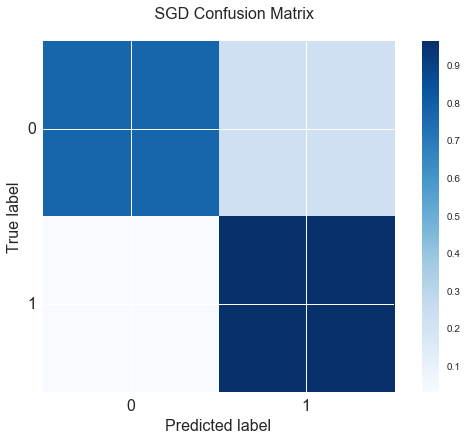

In [44]:
gs_sgd_model = SGDClassifier(alpha=gs.best_params_['alpha'], 
                       loss=gs.best_params_['loss'], 
                       penalty=gs.best_params_['penalty'], 
                       class_weight='balanced',
                       n_jobs = -1)

gs_sgd_model.fit(X_train,y_train)
predictions = gs_sgd_model.predict(X_test)

# CVscores = cross_val_score(gs_sgd_model, X, y, cv=cv)
# print("CV Accuracy: %0.3f (+/- %0.3f)" % (CVscores.mean(), CVscores.std() * 1.96)) #95% confidence interval

labels = [0,1]
conf = confusion_matrix(y_test,predictions,labels)
acc = accuracy_score(y_test,predictions)

print ('Train/Test Accuracy: %0.3f \n' % acc)
print ('Confusion Matrix:')
print (conf)

plt.figure(figsize=(8, 6))
conf_normalized = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(conf_normalized, 
                      title='       SGD Confusion Matrix\n',
                      labels=labels)

Decent Accuracy but it won't win a Kaggle competition. The bar chart below visually demonstrates the most influential features in the model. 

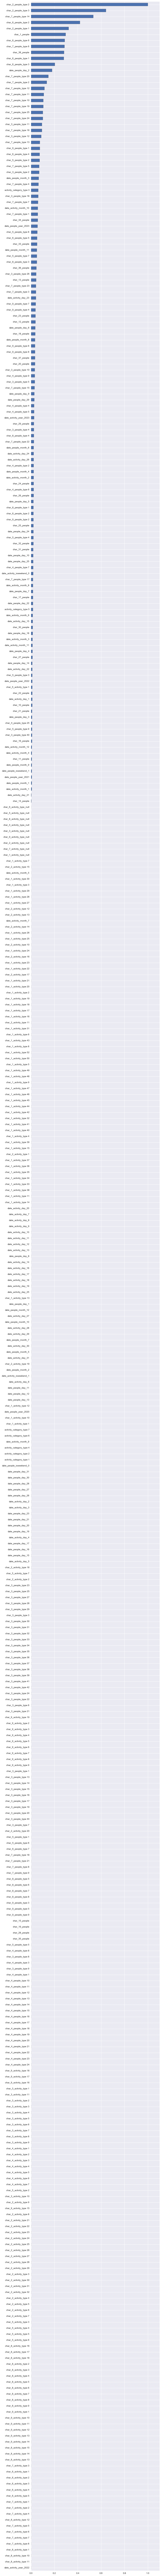

In [45]:
plt.figure(figsize=(10, 200))
weights = pd.Series(abs(gs_sgd_model.coef_[0]),index=colX)
weights = weights/(abs(weights).max())
weights = weights.sort_values(ascending=True)
weights.plot(kind='barh')
plt.xlim([0,1.1])
plt.show()

### Random Forests

In [46]:
parameters = {'n_estimators': [20,30,40],
              'criterion':['entropy','gini']}

rf = RandomForestClassifier(class_weight='balanced')
gs = GridSearchCV(rf, parameters, cv=cv_sampled, verbose = 1)

gs.fit(X_sampled, y_sampled)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.5min finished


GridSearchCV(cv=ShuffleSplit(54932, n_iter=3, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 30, 40], 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [47]:
sorted(gs.grid_scores_,key=lambda x: x[1], reverse=True)

[mean: 0.90409, std: 0.00290, params: {'n_estimators': 40, 'criterion': 'entropy'},
 mean: 0.90366, std: 0.00292, params: {'n_estimators': 40, 'criterion': 'gini'},
 mean: 0.90303, std: 0.00258, params: {'n_estimators': 30, 'criterion': 'entropy'},
 mean: 0.90245, std: 0.00186, params: {'n_estimators': 30, 'criterion': 'gini'},
 mean: 0.90148, std: 0.00281, params: {'n_estimators': 20, 'criterion': 'entropy'},
 mean: 0.89968, std: 0.00138, params: {'n_estimators': 20, 'criterion': 'gini'}]

In [48]:
print (gs.best_score_, gs.best_params_)

0.904085760518 {'n_estimators': 40, 'criterion': 'entropy'}


Train/Test Accuracy: 0.989 

Confusion Matrix:
[[361654   5139]
 [  1981 290414]]


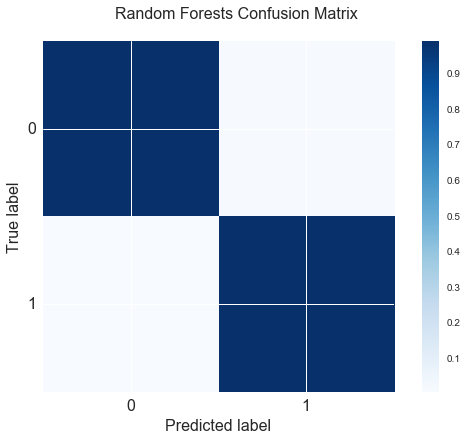

In [49]:
gs_rf_model = RandomForestClassifier(n_estimators = gs.best_params_['n_estimators'],
                                    criterion = gs.best_params_['criterion'],
                                    class_weight = 'balanced',
                                    n_jobs=-1)

gs_rf_model.fit(X_train, y_train)
predictions = gs_rf_model.predict(X_test)

# CVscores = cross_val_score(gs_rf_model, X, y, cv=cv)

# print("CV Accuracy: %0.3f (+/- %0.3f)" % (CVscores.mean(), CVscores.std() * 1.96)) #95% confidence interval

labels = [0,1]
conf = confusion_matrix(y_test,predictions,labels)
acc = accuracy_score(y_test,predictions)

print ('Train/Test Accuracy: %0.3f \n' % acc)
print ('Confusion Matrix:')
print (conf)

plt.figure(figsize=(8, 6))
conf_normalized = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(conf_normalized, 
                      title='        Random Forests Confusion Matrix\n',
                      labels=labels)

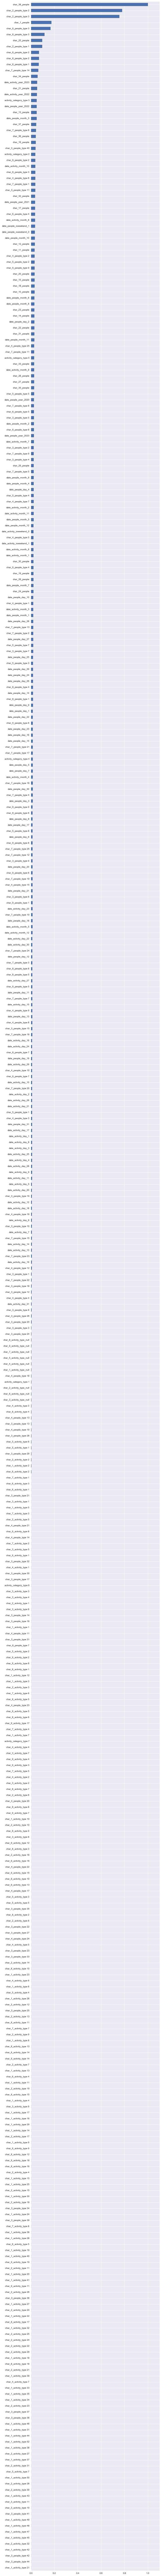

In [50]:
plt.figure(figsize=(10, 200))
weights = pd.Series(abs(gs_rf_model.feature_importances_), index=colX)
#weights = pd.Series(gs_rf_model.feature_importances_,index=colX)
weights = weights/(abs(weights).max())
weights = weights.sort_values(ascending=True)
weights.plot(kind='barh')
plt.xlim([0,1.1])
plt.show()

### Finalize with RandomForests

In [51]:
gs_rf_model_final = RandomForestClassifier(n_estimators = 40,
                                           criterion = 'entropy',
                                           class_weight = 'balanced',
                                           n_jobs=-1, 
                                           verbose = 1)

gs_rf_model_final.fit(X,y)

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.3min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

### Get Predictions for Submission

In [52]:
gs_rf_model_final.predict(test[colX])

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    2.2s finished


array([ 0.,  0.,  1., ...,  0.,  0.,  0.])

In [53]:
prob = gs_rf_model_final.predict_proba(test[colX])

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    2.1s finished


In [54]:
prob = pd.Series(data = prob[:,1], index=test.index)

In [55]:
submission = pd.concat([test['activity_id'], prob], axis = 1)
submission = submission.rename(columns={0:'outcome'})
submission = submission.sort_values('activity_id', ascending = True)

In [56]:
print (submission.shape)
submission.head()

(498687, 2)


,activity_id,outcome
2437973,act1_1,0.80
2276989,act1_100006,0.00
2555511,act1_100050,0.75
2257069,act1_100065,0.05
2315094,act1_100068,0.00


In [57]:
submission.to_csv('submission.csv', encoding='utf-8', index=False)

### Data Viz

From the feature_importances attribute, we've gathered that there are three main features contributing the most to the Random Forests Model:

- char_38
- char_2_people_type2
- char_2_people_type3

Char 38 being the only continuous variable and both other variables being a people characteristic. If we look at the histograms of these features by outcome, we can see how they separate the outcomes. 

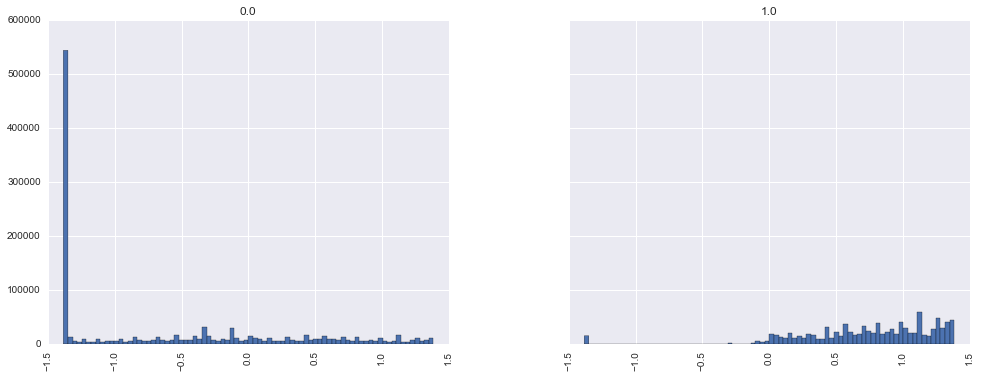

In [58]:
df.char_38_people.hist(bins = 80, figsize=(16,6), by=df.outcome, sharey = True)
plt.show()

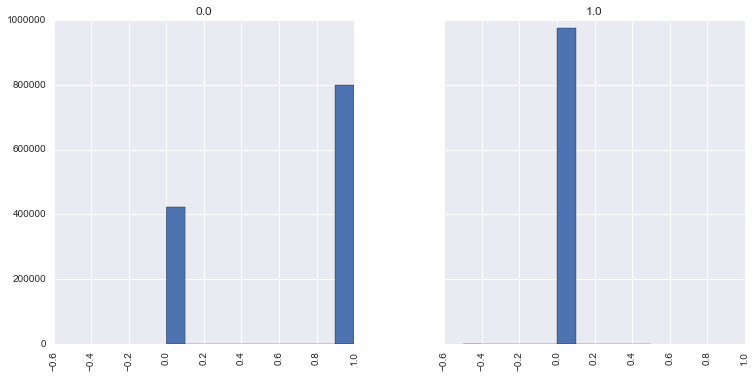

In [59]:
df['char_2_people_type 2'].hist(by=df.outcome, sharex = True, sharey = True, figsize = (12,6))
plt.show()

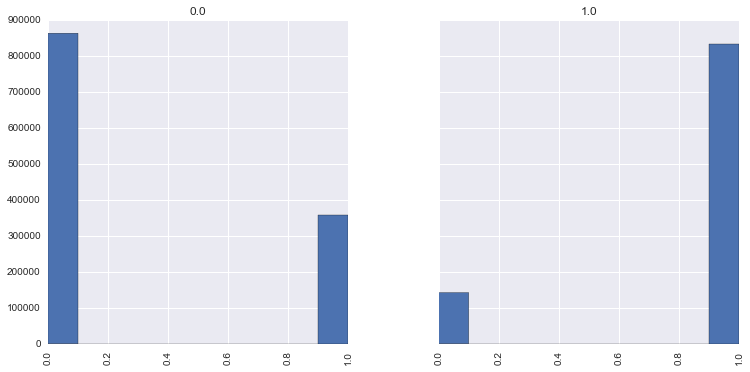

In [60]:
df['char_2_people_type 3'].hist(by=df.outcome, sharex = True, sharey = True, figsize = (12,6))
plt.show()